## Beam deflection with double integration

In [2]:
%matplotlib widget
# Documentation needed for ipyml - notifications on push from github

from bmcs_utils.api import InteractiveModel, InteractiveWindow, Item, View
from bmcs_beam.models.moment_curvature.moment_curvature_ import MomentCurvature

import numpy as np
import sympy as sp
import traits.api as tr
import matplotlib.pylab as plt

from matplotlib.path import Path
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch
import ipywidgets as widgets

from scipy.integrate import cumtrapz
sp.init_printing()

from scipy.signal import find_peaks
from sympy.physics.continuum_mechanics.beam import Beam
# https://docs.sympy.org/latest/modules/physics/continuum_mechanics/beam_problems.html

In [3]:
"beam configuration examples"

# 3 span distributed load beam definition

x, E, I, F = sp.symbols('x E I F')
l = sp.symbols('l', positive=True)
b3s = Beam(l, E, I)
R1,R2,R3,R4 = sp.symbols('R1 R2 R3 R4')
b3s.apply_load(R1, 0, -1)
b3s.apply_load(R2, l/3, -1)
b3s.apply_load(R3, 2*l/3, -1)
b3s.apply_load(R4, l, -1)
b3s.apply_load(-F, 0, 0)
b3s.bc_deflection = [(0, 0),(l/3, 0),(2*l/3, 0),(l, 0)]
b3s.solve_for_reaction_loads(R1, R2, R3,R4)

# 3 point bending beam definition
'''
                       F
                       |
 ______________________V________________________
|_______________________________________________|
o                      |                       /\
|----------------------|-----------------------|
        L/2                     L/2
        
'''
x, E, I, F = sp.symbols('x E I F')
l = sp.symbols('l', positive=True) # the l sign
b3p = Beam(l, E, I)
R1,R2 = sp.symbols('R1 R2')
b3p.apply_load(R1, 0, -1)
b3p.apply_load(R2, l, -1)
b3p.apply_load(-F, l/2, -1)
b3p.bc_deflection = [(0, 0),(l, 0)]
b3p.solve_for_reaction_loads(R1, R2)

# 4 point bending beam definition
'''
                F               F
                |               |
 _______________V_______________V___________-___
|_______________________________________________|
o                                              /\
|---------------|---------------|----------------|
      L/3             L/3                 L/3
         
'''
x, E, I, F = sp.symbols('x E I F')
l = sp.symbols('l', positive=True)
b4p = Beam(l, E, I)
R1,R2 = sp.symbols('R1  R2')
b4p.apply_load(R1, 0, -1)
b4p.apply_load(R2, l, -1)
b4p.apply_load(-F, l/3, -1)
b4p.apply_load(-F, 2*l/3, -1)
b4p.bc_deflection = [(0, 0),(l, 0)]
b4p.solve_for_reaction_loads(R1, R2)


# distrubuted load simple beam definition
'''
                     F KN/m
_________________________________________________                                                     
| | | | | | | | | | | | | | | | | | | | | | | | |                            
V V V V V V V V V V V V V V V V V V V V V V V V V                                                     
 _______________________________________________
|_______________________________________________|
o                                              /\
|-----------------------------------------------|
                       L
        
'''
E,I,M,V = sp.symbols('E I M V')
bdi = Beam(l, E, I)
E,I,R1,R2 = sp.symbols('E I R1 R2')
bdi.apply_load(R1, 0, -1)
bdi.apply_load(R2, l, -1)
bdi.apply_load(-F, 0, 0)
bdi.bc_deflection = [(0, 0),(l, 0)]
bdi.solve_for_reaction_loads(R1, R2)


# fixed support beam definition
'''
                                      ^ y
                                      |
                                      ---> x
\\\\|                  F                  |\\\\
\\\\|                  |                  |\\\\
\\\\|                  V                  |\\\\
\\\\|_____________________________________|\\\\
\\\\|_____________________________________|\\\\
\\\\|                  :                  |\\\\
\\\\|                  :                  |\\\\
\\\\|------------------|------------------|\\\\
             l/2                l/2
'''

E, I, F = sp.symbols('E I F')
# l = sp.symbols('l', positive=True)
bf = Beam(l, E, I)
R1,R2 = sp.symbols('R1  R2')
M1, M2 = sp.symbols('M1, M2')
bf.apply_load(R1, 0, -1)
bf.apply_load(M1, 0, -2)
bf.apply_load(R2, l, -1)
bf.apply_load(M2, l, -2)
bf.apply_load(-F, 5, -1)
bf.bc_deflection = [(0, 0),(l, 0)]
bf.bc_slope = [(0, 0),(l, 0)]
bf.solve_for_reaction_loads(R1, R2, M1, M2)

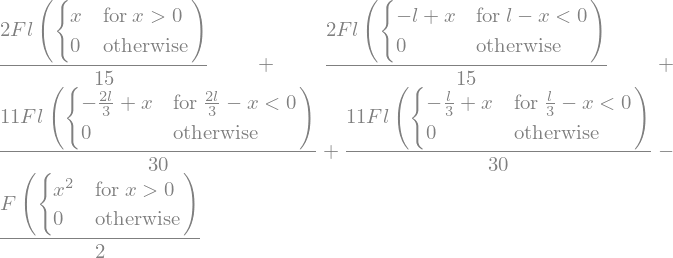

In [4]:
conf_name = b3s # beam configuration name

M_ = conf_name.bending_moment().rewrite(sp.Piecewise)
M_

In [5]:
get_M = sp.lambdify((x,F,l), M_)

In [6]:
mc = MomentCurvature()
# mc.A_j = 2323  
# Update the variables in the moment curvature package

In [12]:
class CrossSectionDesign(InteractiveModel):

    name = 'CrossSectionDesign'
   
    # Reinforcement
    E_carbon = tr.Int(200000)
    width = tr.Float(8)
    thickness = tr.Float(1)
    spacing = tr.Float(1)
    n_layers = tr.Int(1)
    A_roving = tr.Float(1)
    f_h = tr.Int(5)

    #Concerte cross section
#     L = tr.Int(5000, param=True, latex='L \mathrm{mm}', minmax=(10,10000))
    H = tr.Int(10)
    B = tr.Int(10)
    E_con = tr.Int(14000)
    F = tr.Float(10)
    n_x = tr.Int(100)
    
    ipw_view = View(
        Item('E_carbon', param=True, latex='E_r \mathrm{[MPa]}', minmax=(200000,300000)),
        Item('width', param=True, latex='rov_w \mathrm{[mm]}', minmax=(8,450)),
        Item('thickness', param=True, latex='rov_t \mathrm{[mm]}', minmax=(1,100)),
        Item('spacing', param=True, latex='ro_s \mathrm{[mm]}', minmax=(1,100)),
        Item('n_layers', param=True, latex='n_l \mathrm{[-]}', minmax=(1,100)),
        Item('A_roving', param=True, latex='A_r \mathrm{[mm^2]}', minmax=(1,100)),
        Item('f_h', param=True, latex='f_h \mathrm{[mm]}', minmax=(5,500)),
        Item('H', param=True, latex='H \mathrm{[mm]}', minmax=(10,500)),
        Item('B', param=True, latex='B \mathrm{[mm]}', minmax=(10,500)),
        Item('E_con', param=True, latex='E \mathrm{[MPa]}', minmax=(14000,41000)),
        Item('F', param=True, latex='F \mathrm{[N]}', minmax=(10,1000)),
        Item('n_x', param=True, latex='n_x \mathrm{[-]}', minmax=(1,1000))
    )
    
    def get_comp_E(self):
        '''todo: check it with the bmcs example'''
        A_composite = self.B * self.H
        n_rovings = self.width / self.spacing # width or B??
        A_layer = n_rovings * self.A_roving 
        A_carbon = self.n_layers * A_layer 
        A_concrete = A_composite - A_carbon 
        E_comp = (self.E_carbon * A_carbon + self.E_con * A_concrete) / (A_composite)
        return E_comp
      
    def subplots(self, fig):
        return fig.subplots(1, 1)

    def update_plot(self, ax):     
        ax.axis([0, self.B, 0, self.H]);
        ax.axis('equal');
        ax.fill([0,self.B,self.B,0,0], [0,0,self.H,self.H,0],color='gray')
        ax.plot([0,self.B,self.B,0,0], [0,0,self.H,self.H,0],color='black')
        ax.plot([self.B/2 - self.width/2, self.B/2 + self.width/2], 
                [self.f_h,self.f_h],color='Blue',
                linewidth=self.n_layers*self.thickness)       
        ax.annotate('E_composite = {} GPa'.format(np.round(self.get_comp_E()/1000),0),
                xy=(self.B/10,self.f_h*1.1), color='white')

In [13]:
beam_cs_layout = CrossSectionDesign()
bc_ii = InteractiveWindow(beam_cs_layout)
bc_ii.interact()

In [19]:
class BeamDesign(InteractiveModel):
    
    cs_layout = tr.Instance(CrossSectionDesign)
    
    name = 'BeamDesign'
   
    L = tr.Int(5000)
    H = tr.Int(200)
    ipw_view = View(
        Item('L', latex='L \mathrm{[mm]}', minmax=(1000,10000)),
        Item('H', latex='H \mathrm{[mm]}', minmax=(100,500))
    )
    
    def beamdefine(self):
        pass
    
    def subplots(self, fig):
        return fig.subplots(1, 1)

    def update_plot(self, ax):  
        
        ax.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
        ax.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
        ax.annotate('L = {} mm'.format(np.round(self.L),0),
                xy=(self.L/2,self.H * 1.1), color='black')
        ax.axis('equal')

In [20]:
beam_design = BeamDesign(cs_layout=beam_cs_layout)
InteractiveWindow([beam_design, beam_design.cs_layout]).interact()

In [ ]:
class BoundaryConditions(InteractiveModel):
    
    name = 'BoundaryConditions'
    
    beam_design = tr.Instance(BeamDesign)
    
    L = tr.DelegatesTo('beam_design')
    H = tr.DelegatesTo('beam_design')
#    L = tr.Int(5000, param=True, latex='L \mathrm{[mm]}', minmax=(1000,10000))
#    H = tr.Int(200, param=True, latex='H \mathrm{[mm]}', minmax=(10,500))
    F = tr.Float(1000)
    n_sup = tr.Int(2)
    G_adj = tr.Float(0.02)
    F_pos = tr.Int(2500)

    ipw_view = View(
        Item('F', param=True, latex='F \mathrm{[N]}', minmax=(1000,10000)),
        Item('n_sup', param=True, latex='n_{sup} \mathrm{[-]}', minmax=(2,10)), #number of supports
        Item('G_adj', param=True, latex='G_{adj} \mathrm{[-]}', minmax=(1e-3,1e-1)), #Graphic adjustment factor
        Item('F_pos', param=True, latex='F_{pos} \mathrm{[mm]}', minmax=(0,10000)), # Force position
    )


#     def apply_support(self, loc, type="fixed"):
#         """
#         This method applies support to a particular beam object.
#         Parameters
#         ==========
#         loc : Sympifyable
#             Location of point at which support is applied.
#         type : String
#             Determines type of Beam support applied. To apply support structure
#             with
#             - zero degree of freedom, type = "fixed"
#             - one degree of freedom, type = "pin"
#             - two degrees of freedom, type = "roller"
            
#             """
#         pass
    
    def suploc (self):
        # reading the position of the boundary conditions
        beam_name = conf_name
        loc_d_ = []
        loc_s_ = []

        for i in range (0,len(beam_name.bc_deflection)):
            loc_d_.append(beam_name.bc_deflection[i][0])
        for i in range (0,len(beam_name.bc_slope)):
            loc_s_.append(beam_name.bc_slope[i][0])

        loc_d = dict(list(enumerate(loc_d_)))     # a dic of the position of boundary conditions with confined deflection
        loc_d_l_ = sp.lambdify((l),loc_d)
        loc_d_l = (loc_d_l_(self.L))

        loc_s = dict(list(enumerate(loc_s_)))     # the position of boundary conditions with confined sloope
        loc_s_l_ = sp.lambdify((l),loc_s)
        loc_s_l = (loc_s_l_(self.L))    
    
        return loc_d_l
    
    def subplots(self, fig):
        return fig.subplots(1, 1)

    def update_plot(self, ax):  
        
        ax.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
        ax.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
                
        vertices = []
        codes = []
        
        codes = [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY]
        vertices = [(-self.L * self.G_adj, -self.L * self.G_adj), (0, 0),
                    (self.L * self.G_adj, -self.L * self.G_adj), 
                    (-self.L * self.G_adj, -self.L * self.G_adj)]
        
        for i in range (1, len((self.suploc()))):

            codes += [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY] 
            vertices += [(self.suploc()[i] - self.L * (self.G_adj), -self.L * self.G_adj),
                         (self.suploc()[i] , 0),
                         (self.suploc()[i] + self.L * (self.G_adj), -self.L * self.G_adj), 
                         (self.suploc()[i] - self.L * (self.G_adj), -self.L * self.G_adj)]

            codes += [Path.MOVETO] + [Path.LINETO] + [Path.CLOSEPOLY] 
            vertices += [(self.suploc()[i] + (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                         (self.suploc()[i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                         (self.suploc()[i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2)]

        vertices = np.array(vertices, float)
        path = Path(vertices, codes)
        pathpatch = PathPatch(path, facecolor='None', edgecolor='green')
        ax.add_patch(pathpatch)
        ax.plot((0,self.L*1),(0,0))
        
        x_tail = self.F_pos
        y_tail = self.L/20 + self.H
        x_head = self.F_pos
        y_head = 0 + self.H
        dy = y_head + x_head/10
        arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                         color = 'blue',mutation_scale=self.L/500)
        ax.annotate('{} KN'.format(np.round(self.F/1000),0),
                xy=(x_tail,y_tail), color='black')
        ax.add_patch(arrow)
        
        ax.axis('equal')
        ax.autoscale(tight=True)

In [ ]:
beam_bc = BoundaryConditions(beam_design=beam_design)
InteractiveWindow([beam_bc,beam_bc.beam_design,beam_bc.beam_design.cs_layout]).interact()

In [ ]:
class Beam3PtBending(InteractiveModel):
    '''
    Todo: 1- moving point load, line load, load combinations
    '''
    name = 'Analysis'

#     boundarycondition = tr.Instance(BoundaryConditions)
#     def _boundarycondition_default(self):
#         return BoundaryConditions()

    bc_d = tr.Instance(BoundaryConditions,())
    bc = bc_d.suploc()

    mc = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_mc(self):
        mc_ = MomentCurvature()
        return mc_
    
    # Reinforcement
    E_carbon = tr.Int(200000)
    width = tr.Float(10)
    thickness = tr.Float(1)
    spacing = tr.Float(1)
    n_layers = tr.Int(1)
    A_roving = tr.Float(1)
    
    #Concerte cross section
    L = tr.Int(5000, param=True, latex='L \mathrm{mm}', minmax=(10,10000))
    H = tr.Int(200, param=True, latex='H \mathrm{mm}', minmax=(10,500))
#     B = tr.Int(10, param=True, latex='B \mathrm{mm}', minmax=(10,500))
    E_con = tr.Int(14000)
    F = tr.Float(5000)
    n_x = tr.Int(100)
    G_adj = tr.Float(0.02)

    ipw_view = View(
        Item('E_con', param=True, latex='E \mathrm{MPa}', minmax=(14000,41000)) ,
        Item('F', param=True, latex='F \mathrm{N}', minmax=(10,100000)),
        Item('E_carbon', param=True, latex='E_r \mathrm{MPa}', minmax=(200000,300000)),
        Item('width', param=True, latex='rov_w \mathrm{mm}', minmax=(10,450)),
        Item('thickness', param=True, latex='rov_t \mathrm{mm}', minmax=(1,100)),
        Item('spacing', param=True, latex='ro_s \mathrm{mm}', minmax=(1,100)),
        Item('n_layers', param=True, latex='n_l \mathrm{-}', minmax=(1,100)),
        Item('A_roving', param=True, latex='A_r \mathrm{mm^2}', minmax=(1,100)),
        Item('G_adj', param=True, latex='G_{adj} \mathrm{-}', minmax=(1e-3,1e-1)),
        Item('n_x',param=True, latex='n_x \mathrm{-}', minmax=(1,1000))
    )

    x = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_x(self):
        return np.linspace(0,self.L,self.n_x)
    
    E_comp = tr.Property(depends_on = '+param')
    @tr.cached_property
    
    def _get_E_comp(self):
        A_composite = self.B * self.H
        n_rovings = self.width / self.spacing 
        A_layer = n_rovings * self.A_roving 
        A_carbon = self.n_layers * A_layer 
        A_concrete = A_composite - A_carbon 
        E_comp = (self.E_carbon * A_carbon + self.E_con * A_concrete) / (A_composite)
        return E_comp   

    def get_M_x(self):
        M_x = get_M(self.x, self.F, self.L)
        return M_x
    
    def get_kappa_x(self):
        M = self.get_M_x()
#         I = (self.B*self.H**3)/12
        return mc.get_kappa(M)
#         return M / I / self.E_comp
    
#     #b3p, b4p & bdi
    def get_phi_x(self):
        kappa_x = self.get_kappa_x()
        phi_x = cumtrapz(kappa_x, self.x, initial=0)
        phi_L2 = np.interp(self.L/2, self.x, phi_x)
        phi_x -= phi_L2
        return phi_x
    
    #b3s
#     def get_phi_x(self):
#         kappa_x = self.get_kappa_x()
#         phi_x = cumtrapz(kappa_x, self.x, initial=0)
#         peaks, _ = find_peaks(M_x, height=0)
#         M_x_p = M_x[peaks]
#         phi_L2 = np.interp(self.M_x_p, self.x, phi_x)
#         phi_x -= phi_L2
#         return phi_x
    
    def get_w_x(self):
        phi_x = self.get_phi_x()
        w_x = cumtrapz(phi_x, self.x, initial=0)
        w_x += w_x[0]
        return w_x
    
    def subplots(self, fig):
        return fig.subplots(3, 1)

    def update_plot(self, axes):
        ax1, ax2, ax3 = axes
        
        ax1.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
        ax1.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
                
        vertices = []
        codes = []
        
        codes = [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY]
        vertices = [(-self.L * self.G_adj, -self.L * self.G_adj),
                    (0, 0),
                    (self.L * self.G_adj, -self.L * self.G_adj), 
                    (-self.L * self.G_adj, -self.L * self.G_adj)]
        
        for i in range (1, len(self.bc)):

            codes += [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY] 
            vertices += [(self.bc[i] - self.L * (self.G_adj), -self.L * self.G_adj),
                         (self.bc[i] , 0),
                         (self.bc[i] + self.L * (self.G_adj), -self.L * self.G_adj), 
                         (self.bc[i] - self.L * (self.G_adj), -self.L * self.G_adj)]

            codes += [Path.MOVETO] + [Path.LINETO] + [Path.CLOSEPOLY] 
            vertices += [(self.bc[i] + (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                         (self.bc[i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                         (self.bc[i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2)]
            
        vertices = np.array(vertices, float)
        path = Path(vertices, codes)

        pathpatch = PathPatch(path, facecolor='None', edgecolor='green')

        ax1.add_patch(pathpatch)
        ax1.plot((0,self.L*1),(0,0))

        x_tail = self.L/2
        y_tail = self.F * self.G_adj + self.H
        x_head = self.L/2
        y_head = 0 + self.H
        dy = y_head + x_head/10
        arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                          mutation_scale=10)
        ax1.add_patch(arrow)
        ax1.axis('auto');
        
        x = self.x
        
        M_x = self.get_M_x()
        ax2.plot(x, -M_x, color='red', label='moment [N.mm]')
        leg = ax2.legend();
        
        kappa_x = self.get_kappa_x()
        ax3.plot(x, kappa_x, color='black', label='$kappa$ [-]')
        leg = ax3.legend();
        
#         phi_x = self.get_phi_x()
#         ax4.plot(x, phi_x, color='green', label='phi [-]')
#         leg = ax4.legend();
        
#         w_x = self.get_w_x()
#         ax5.plot(x, w_x, color='blue', label='$w$ [mm]')
#         leg = ax5.legend();

In [21]:
# bd = Beam3PtBending()
ibd = InteractiveWindow([Beam3PtBending(),BeamDesign(),BoundaryConditions(),CrossSectionDesign()])
ibd.interact()

In [22]:
beam_bc = BoundaryConditions(beam_design=beam_design)
InteractiveWindow([beam_bc,beam_bc.beam_design,beam_bc.beam_design.cs_layout]).interact()

In [ ]:
class Beam3PtBending(InteractiveModel):
    '''
    Todo: 1- moving point load, line load, load combinations
    '''
    name = 'Analysis'

#     boundarycondition = tr.Instance(BoundaryConditions)
#     def _boundarycondition_default(self):
#         return BoundaryConditions()

    bc_d = tr.Instance(BoundaryConditions,())
    bc = bc_d.suploc()

    mc = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_mc(self):
        mc_ = MomentCurvature()
        return mc_
    
    # Reinforcement
    E_carbon = tr.Int(200000)
    width = tr.Float(10)
    thickness = tr.Float(1)
    spacing = tr.Float(1)
    n_layers = tr.Int(1)
    A_roving = tr.Float(1)
    
    #Concerte cross section
    L = tr.Int(5000, param=True, latex='L \mathrm{mm}', minmax=(10,10000))
    H = tr.Int(200, param=True, latex='H \mathrm{mm}', minmax=(10,500))
#     B = tr.Int(10, param=True, latex='B \mathrm{mm}', minmax=(10,500))
    E_con = tr.Int(14000)
    F = tr.Float(5000)
    n_x = tr.Int(100)
    G_adj = tr.Float(0.02)

    ipw_view = View(
        Item('E_con', param=True, latex='E \mathrm{MPa}', minmax=(14000,41000)) ,
        Item('F', param=True, latex='F \mathrm{N}', minmax=(10,100000)),
        Item('E_carbon', param=True, latex='E_r \mathrm{MPa}', minmax=(200000,300000)),
        Item('width', param=True, latex='rov_w \mathrm{mm}', minmax=(10,450)),
        Item('thickness', param=True, latex='rov_t \mathrm{mm}', minmax=(1,100)),
        Item('spacing', param=True, latex='ro_s \mathrm{mm}', minmax=(1,100)),
        Item('n_layers', param=True, latex='n_l \mathrm{-}', minmax=(1,100)),
        Item('A_roving', param=True, latex='A_r \mathrm{mm^2}', minmax=(1,100)),
        Item('G_adj', param=True, latex='G_{adj} \mathrm{-}', minmax=(1e-3,1e-1)),
        Item('n_x',param=True, latex='n_x \mathrm{-}', minmax=(1,1000))
    )

    x = tr.Property(depends_on = '+param')
    @tr.cached_property
    def _get_x(self):
        return np.linspace(0,self.L,self.n_x)
    
    E_comp = tr.Property(depends_on = '+param')
    @tr.cached_property
    
    def _get_E_comp(self):
        A_composite = self.B * self.H
        n_rovings = self.width / self.spacing 
        A_layer = n_rovings * self.A_roving 
        A_carbon = self.n_layers * A_layer 
        A_concrete = A_composite - A_carbon 
        E_comp = (self.E_carbon * A_carbon + self.E_con * A_concrete) / (A_composite)
        return E_comp   

    def get_M_x(self):
        M_x = get_M(self.x, self.F, self.L)
        return M_x
    
    def get_kappa_x(self):
        M = self.get_M_x()
#         I = (self.B*self.H**3)/12
        return mc.get_kappa(M)
#         return M / I / self.E_comp
    
#     #b3p, b4p & bdi
    def get_phi_x(self):
        kappa_x = self.get_kappa_x()
        phi_x = cumtrapz(kappa_x, self.x, initial=0)
        phi_L2 = np.interp(self.L/2, self.x, phi_x)
        phi_x -= phi_L2
        return phi_x
    
    #b3s
#     def get_phi_x(self):
#         kappa_x = self.get_kappa_x()
#         phi_x = cumtrapz(kappa_x, self.x, initial=0)
#         peaks, _ = find_peaks(M_x, height=0)
#         M_x_p = M_x[peaks]
#         phi_L2 = np.interp(self.M_x_p, self.x, phi_x)
#         phi_x -= phi_L2
#         return phi_x
    
    def get_w_x(self):
        phi_x = self.get_phi_x()
        w_x = cumtrapz(phi_x, self.x, initial=0)
        w_x += w_x[0]
        return w_x
    
    def subplots(self, fig):
        return fig.subplots(3, 1)

    def update_plot(self, axes):
        ax1, ax2, ax3 = axes
        
        ax1.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
        ax1.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
                
        vertices = []
        codes = []
        
        codes = [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY]
        vertices = [(-self.L * self.G_adj, -self.L * self.G_adj),
                    (0, 0),
                    (self.L * self.G_adj, -self.L * self.G_adj), 
                    (-self.L * self.G_adj, -self.L * self.G_adj)]
        
        for i in range (1, len(self.bc)):

            codes += [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY] 
            vertices += [(self.bc[i] - self.L * (self.G_adj), -self.L * self.G_adj),
                         (self.bc[i] , 0),
                         (self.bc[i] + self.L * (self.G_adj), -self.L * self.G_adj), 
                         (self.bc[i] - self.L * (self.G_adj), -self.L * self.G_adj)]

            codes += [Path.MOVETO] + [Path.LINETO] + [Path.CLOSEPOLY] 
            vertices += [(self.bc[i] + (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                         (self.bc[i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2),
                         (self.bc[i] - (self.L * self.G_adj), -self.L * self.G_adj*1.2)]
            
        vertices = np.array(vertices, float)
        path = Path(vertices, codes)

        pathpatch = PathPatch(path, facecolor='None', edgecolor='green')

        ax1.add_patch(pathpatch)
        ax1.plot((0,self.L*1),(0,0))

        x_tail = self.L/2
        y_tail = self.F * self.G_adj + self.H
        x_head = self.L/2
        y_head = 0 + self.H
        dy = y_head + x_head/10
        arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                          mutation_scale=10)
        ax1.add_patch(arrow)
        ax1.axis('auto');
        
        x = self.x
        
        M_x = self.get_M_x()
        ax2.plot(x, -M_x, color='red', label='moment [N.mm]')
        leg = ax2.legend();
        
        kappa_x = self.get_kappa_x()
        ax3.plot(x, kappa_x, color='black', label='$kappa$ [-]')
        leg = ax3.legend();
        
#         phi_x = self.get_phi_x()
#         ax4.plot(x, phi_x, color='green', label='phi [-]')
#         leg = ax4.legend();
        
#         w_x = self.get_w_x()
#         ax5.plot(x, w_x, color='blue', label='$w$ [mm]')
#         leg = ax5.legend();

In [ ]:
# bd = Beam3PtBending()
ibd = InteractiveWindow([Beam3PtBending(),BeamDesign(),BoundaryConditions(),CrossSectionDesign()])
ibd.interact()